In [1]:
import pathlib
import sys 
import random
import json
import cv2 
import base64
import requests as req
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from io import BytesIO  
%matplotlib inline

In [2]:
'/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages' in sys.path

True

#Importing CourtSeg

In [3]:
'''
Importing courtseg looks for the accuract function in this file as well
'''
def acc_courtSeg(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [4]:
import import_ipynb
import CourtSeg

importing Jupyter notebook from CourtSeg.ipynb


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'fastai.vision.models.unet.DynamicUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modu

<Figure size 432x288 with 0 Axes>

In [4]:
img = cv2.imread('/Users/sandeep/Desktop/dataandmodles/data/cavs.JPG')

In [5]:

x = CourtSeg.getCourtMask(img)

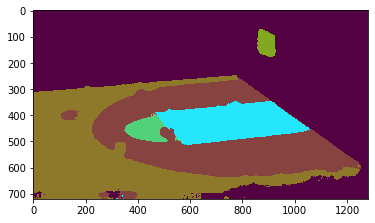

In [6]:
plt.imshow(x)

#Pose

In [5]:
#constants
PART_NAMES = [
    "nose", "leftEye", "rightEye", "leftEar", "rightEar", "leftShoulder",
    "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
    "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"
]
PART_IDS = {pn: pid for pid, pn in enumerate(PART_NAMES)} ;PART_IDS
CONNECTED_PART_NAMES = [
    ("leftHip", "leftShoulder"), ("leftElbow", "leftShoulder"),
    ("leftElbow", "leftWrist"), ("leftHip", "leftKnee"),
    ("leftKnee", "leftAnkle"), ("rightHip", "rightShoulder"),
    ("rightElbow", "rightShoulder"), ("rightElbow", "rightWrist"),
    ("rightHip", "rightKnee"), ("rightKnee", "rightAnkle"),
    ("leftShoulder", "rightShoulder"), ("leftHip", "rightHip")
]

CONNECTED_PART_INDICES = [(PART_IDS[a], PART_IDS[b]) for a, b in CONNECTED_PART_NAMES]; CONNECTED_PART_INDICES

[(11, 5),
 (7, 5),
 (7, 9),
 (11, 13),
 (13, 15),
 (12, 6),
 (8, 6),
 (8, 10),
 (12, 14),
 (14, 16),
 (5, 6),
 (11, 12)]

In [6]:
def getBase64Image(filePath):
    with open(filePath, "rb") as img_file:
        my_string = base64.b64encode(img_file.read())
        my_string = my_string.decode('utf-8')
    return my_string
    

In [7]:
def convertToBase64(image):
    retval, buffer = cv2.imencode('.jpg', image)
    my_string = base64.b64encode(buffer)
    my_string = my_string.decode('utf-8')
    return my_string
    
  

In [8]:
def get_adjacent_keypoints(keypoints):
    results = []
    for left, right in CONNECTED_PART_INDICES:
       results.append(
           np.array([
                [ keypoints[left]['position']['x'] , keypoints[left]['position']['y'] ],
                [ keypoints[right]['position']['x'] , keypoints[right]['position']['y'] ]
                    ]
           ).astype(np.int32)
        )
    return results
            
        

In [23]:
#Loading model
r = req.get(url='http://localhost:3000/loadModel')


In [10]:
#Sending data to server
def getPoses(image_string):
    url2 = 'http://localhost:3000/postImage'
    data = {'imgBase64':'data:image/png;base64,'+image_string}
    r = req.post(url=url2 , data = data)
    poses = r.json()
    return poses

In [11]:
def draw_keypoints(poses,img):
    cv_keypoints= []
    for pose in poses['detectionList']:
        keypoints = pose['keypoints']
        for keypoint in keypoints:
            x,y,score = round(keypoint['position']['x']) ,round(keypoint['position']['y']),keypoint['score']
            cv_keypoints.append(cv2.KeyPoint(x,y , 10. *score))
    out_img = cv2.drawKeypoints(img, cv_keypoints , outImage=np.array([]) ) 
    

In [12]:
def draw_skelton(poses,img):
    adjacent_keypoints = []
    out_img = img
    for pose in poses['detectionList']:
        keypoints  = pose['keypoints']
        new_keypoints = get_adjacent_keypoints(keypoints)
        adjacent_keypoints.extend(new_keypoints)
    out_img = cv2.polylines(out_img , adjacent_keypoints, isClosed=False, color=(255,255,0))
    return out_img    

In [13]:
def draw_skel_and_kp(poses , img, color):
    out_img = img
    adjacent_keypoints = []
    cv_keypoints = []
    for pose in poses['detectionList']:
        keypoints = pose['keypoints']
        new_keypoint = get_adjacent_keypoints(keypoints)
        adjacent_keypoints.extend(new_keypoint)
        
        for keypoint in keypoints:
            x,y,score = round(keypoint['position']['x']) ,round(keypoint['position']['y']),keypoint['score']
            cv_keypoints.append(cv2.KeyPoint(x,y , 10. * score))
    out_img = cv2.drawKeypoints(
        img, cv_keypoints , outImage=np.array([]), color=color,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS )
    out_img = cv2.polylines(out_img , adjacent_keypoints , isClosed=False, color=list(color))
    return out_img
    
    
        

In [14]:
def mapIntToColours(fraction,totalColors):
    viridis = cm.get_cmap('magma', totalColors)
    rgba = viridis(fraction)
    bgr = ( int((round(rgba[2] *255))) , int((round(rgba[1] *255))) , int((round(rgba[1] *255))) )
    return bgr
    

In [86]:
mapIntToColours((1/58),58)

(90, 7, 7)

In [49]:

img = cv2.imread('/Users/sandeep/Desktop/FinalYearProject/YoutubeScreenshotScrapper/data/test/Screenshot 2020-01-28 at 7.10.58 AM.png')
myString =convertToBase64(img)
poses = getPoses(myString)
out_img = draw_skel_and_kp(poses,img)
cv2.imwrite('/Users/sandeep/Desktop/FinalYearProject/YoutubeScreenshotScrapper/data/test/shootingPoset.jpg' ,out_img) 

True

In [15]:
def resize(frame):
    '''
    Helper function for timeCompressionPose and timeCompressionCourt
    Return resized frame. 
    Such that size of images will match the size of the court mask (output) form courtSeg model
    during the image stacking process
    '''
    frame= cv2.resize(frame , (1280,720))
    return frame

In [16]:
def timeCompressionPose(videoPath):
    #videoPath ='/Users/sandeep/Desktop/FinalYearProject/YoutubeScreenshotScrapper/data/test/PosenetUsingCDN.ipynb.mov'
    cap = cv2.VideoCapture(videoPath)
    totalFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    count =0;
    mergedImage = None;
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            #Do Stuff
            if count%2==0:
                frame = resize(frame)    
                #if count==0: mergedImage = np.zeros(frame.shape, dtype=np.uint8)
                if count==0: mergedImage = CourtSeg.getCourtMask(frame)
                imageString = convertToBase64(frame)
                poses = getPoses(imageString)
                fraction = ((count + 1) / totalFrames)

                color = mapIntToColours(fraction,totalFrames)
                mergedImage = draw_skel_and_kp(poses , mergedImage , color)
            count += 1
        else:
            cap.release()
            break
    cap.release()
    return mergedImage   

In [17]:
#Decided not to use thia
def timeCompressionCourt(videoPath):
    cap = cv2.VideoCapture(videoPath)
    count = 0 
    mergedImage = None
    while cap.isOpened():
        ret,frame = cap.read()
        if ret:
            #Do Stuff
            frame = resize(frame)
            if count == 0: mergedImage = np.zeros(frame.shape, dtype=np.uint8)  
            if count%10 == 0:
                courtMask = CourtSeg.getCourtMask(frame)
                cv2.addWeighted(mergedImage,1,courtMask,0.191 ,0,mergedImage)
            count = count + 1
        else:
            cap.release()
            break
    cap.release()
    return mergedImage

In [18]:
def mergeImage(mergedPose, mergedCourt):
    mergedImage = np.zeros(mergedCourt.shape, dtype=np.uint8) 
    cv2.addWeighted(mergedPose , 1, mergedCourt , 1, 0 , mergedImage)
    return mergedImage

In [19]:
def formDataset(videos,rootDir,outputDir):
    for video in videos:
        if video[0] != '.':
            videoPath = rootDir+'/'+video
            outputPath = outputDir+'/'+video+'.png'
            mergedPose =  timeCompressionPose(videoPath)
#             mergedCourt = timeCompressionCourt(videoPath)
#             mergedImage = mergeImage(mergedPose, mergedCourt)
            cv2.imwrite(outputPath , mergedPose)

#Forming the dataset

In [96]:
#Making 3 pointer dataset
rootDir = '/Volumes/My Passport 1/FinalYearProjectData/ActionClassificaton3/trainVideos/3-Pointer'
outputDir = '/Volumes/My Passport 1/FinalYearProjectData/ActionClassificaton3/trainMerged/3-Pointer'
videos = os.listdir(rootDir)
formDataset(videos, rootDir , outputDir)


In [20]:
#Making Free-throw dataset
rootDir = '/Volumes/My Passport 1/FinalYearProjectData/ActionClassificaton3/trainVideos/Free-throw'
outputDir = '/Volumes/My Passport 1/FinalYearProjectData/ActionClassificaton3/trainMerged/Free-throw'
videos = [video for video in os.listdir(rootDir) if video[0] != '.']
formDataset(videos, rootDir , outputDir)


In [24]:
#Making Dunk dataset
rootDir = '/Volumes/My Passport 1/FinalYearProjectData/ActionClassificaton3/trainVideos/Dunk'
outputDir = '/Volumes/My Passport 1/FinalYearProjectData/ActionClassificaton3/trainMerged/Dunk'
videos = [video for video in os.listdir(rootDir) if video[0] != '.']
formDataset(videos, rootDir , outputDir)

#TestCode

In [17]:
videos

['Dunk42.mov',
 'Dunk43.mov',
 'Dunk44.mov',
 'Dunk45.mov',
 'Dunk46.mov',
 'Dunk47.mov',
 'Dunk48.mov',
 'Dunk49.mov',
 'Dunk50.mov',
 'Dunk51.mov',
 'Dunk52.mov',
 'Dunk53.mov',
 'Dunk54.mov',
 'Dunk55.mov',
 'Dunk56.mov',
 'Dunk57.mov',
 'Dunk58.mov',
 'Dunk59.mov',
 'Dunk60.mov',
 'Dunk61.mov',
 'Dunk62.mov',
 'Dunk63.mov',
 'Dunk64.mov',
 'Dunk65.mov',
 ' .mov']

In [136]:
img = cv2.imread('/Users/sandeep/Desktop/FinalYearProject/YoutubeScreenshotScrapper/data/test/Screenshot 2020-01-28 at 7.10.58 AM.png')

In [137]:
img= cv2.resize(img , (850,480))

In [138]:
cv2.imwrite('/Users/sandeep/Desktop/FinalYearProject/YoutubeScreenshotScrapper/data/test/smaller.png', img)

True

In [89]:
plasma = cm.get_cmap('hot', 60)
print(viridis)

In [34]:
rgba = plasma(0.5)
(rgba[0] * 255, rgba[1] * 255,rgba[2] * 255)


(31.97547, 146.45109, 140.01693)

In [52]:
list(rbga)

[0.959276, 0.921407, 0.151566, 1.0]

In [74]:
(1/totalFrames)*255

4.396551724137931

In [72]:
count

58

In [2]:
100%10

0

In [ ]:
#Test Corut Seg Weighted SUm

In [12]:
rootDir = '/Users/sandeep/Desktop/dataandmodles/u-netDemoImages/3-pointer'
images = os.listdir(rootDir)
weightedSum = None
count = 0
for image in images:
    filePath = rootDir + '/' + image
    img = cv2.imread(filePath)
    if count == 0: weightedSum = np.zeros(img.shape, dtype=np.uint8)
    cv2.addWeighted(weightedSum,1,img,0.01,0,weightedSum)
    count = count+ 1
cv2.imwrite(rootDir+'/weightedSum0.01.png', weightedSum)

True

In [17]:
img = cv2.imread('/Users/sandeep/Desktop/dataandmodles/u-netDemoImages/3-pointer/weightedSum0.01.png')
img2 = np.zeros(img.shape, dtype=np.uint8) 
img3 = np.zeros(img.shape, dtype=np.uint8) 
res = None 
cv2.addWeighted(img,1,img2,1,0,img3)
cv2.imwrite(rootDir+'/merrgedWithBlack.png', img3)

True

In [50]:
from fastai.vision import *


In [51]:
img = cv2.imread('/Users/sandeep/Desktop/dataandmodles/data/cavs.JPG')
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
img = Image(pil2tensor(img, dtype=np.float32).div_(255))
x = CourtSeg.learn.predict(img)

(ImageSegment (1, 720, 1280), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 2, 2,  ..., 0, 0, 0],
          [2, 2, 2,  ..., 0, 0, 0],
          [2, 2, 2,  ..., 0, 0, 0]]]), tensor([[[9.8967e-01, 9.9324e-01, 9.9809e-01,  ..., 9.8061e-01,
           9.5502e-01, 9.0906e-01],
          [9.9625e-01, 9.9825e-01, 9.9922e-01,  ..., 9.9133e-01,
           9.8400e-01, 9.6173e-01],
          [9.9912e-01, 9.9966e-01, 9.9960e-01,  ..., 9.9887e-01,
           9.9869e-01, 9.9578e-01],
          ...,
          [1.1972e-01, 3.9189e-02, 4.7066e-02,  ..., 9.7854e-01,
           9.8673e-01, 9.8633e-01],
          [1.8799e-01, 8.7504e-02, 6.1716e-02,  ..., 9.7148e-01,
           9.6434e-01, 9.6248e-01],
          [2.8900e-01, 2.1058e-01, 1.8747e-01,  ..., 9.2634e-01,
           9.3025e-01, 8.8647e-01]],
 
         [[1.1027e-03, 2.6249e-04, 4.9278e-05,  ..., 1.4401e-03,
           3.1781e-03, 1.3134e-02],
          [1.

In [77]:
img = cv2.imread('/Users/sandeep/Desktop/dataandmodles/u-netDemoImages/3-pointer/14.png')
img2 = cv2.imread('/Users/sandeep/Desktop/dataandmodles/u-netDemoImages/3-pointer/weightedSumPose.png')
img, img2 = resize(img), resize(img2)

In [78]:
rootDir = '/Users/sandeep/Desktop/dataandmodles/u-netDemoImages/3-pointer'

In [68]:


cv2.addWeighted(img2 , 1, img , 1 , 0 , img2 )
cv2.imwrite(rootDir+'/uncompressedStacked2.png', img2)

True